### Importo

In [1]:
import pandas as pd
import re
import numpy as np
import json
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

## Cargo los datos

In [2]:
with open('MensajesLPjson.txt', 'r') as inp:
    data = json.load(inp)

In [3]:
df = pd.DataFrame.from_dict(data, orient = 'index')
df.index = df.index.map(int)
df.sort_index(inplace=True)
df.head(5)

,request_msg_id,confirm_received,rpc_error,content_related,out,mentioned,media_unread,silent,post,id,...,reply_markup,entities,views,edit_date,post_author,grouped_id,name,username,phone,action
200,0,<threading.Event object at 0x7fd777521780>,None,False,False,False,False,False,False,200,...,None,None,None,None,None,None,Nacho,None,541140577323,NaN
201,0,<threading.Event object at 0x7fd777521860>,None,False,False,False,False,False,False,201,...,None,None,None,None,None,None,None,None,None,NaN
202,0,<threading.Event object at 0x7fd7775216d8>,None,False,False,False,False,False,False,202,...,None,None,None,None,None,None,None,None,None,NaN
203,0,<threading.Event object at 0x7fd777521a58>,None,False,False,False,False,False,False,203,...,None,None,None,None,None,None,None,None,None,NaN
204,0,<threading.Event object at 0x7fd7775215f8>,None,False,False,False,False,False,False,204,...,None,None,None,None,None,None,Nacho,None,541140577323,NaN


## Preprocesamiento

In [4]:
df.columns

Index(['request_msg_id', 'confirm_received', 'rpc_error', 'content_related',
       'out', 'mentioned', 'media_unread', 'silent', 'post', 'id', 'from_id',
       'to_id', 'fwd_from', 'via_bot_id', 'reply_to_msg_id', 'date', 'message',
       'media', 'reply_markup', 'entities', 'views', 'edit_date',
       'post_author', 'grouped_id', 'name', 'username', 'phone', 'action'],
      dtype='object')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['id'] = pd.to_numeric(df['id'])
df = df.groupby('id').agg('first')
df.replace('Facundo Sebastián', 'Facu', inplace=True)
df.replace('None', 'Facu', inplace=True)
df.message.fillna('', inplace=True)

#drop bots and people with few msgs

#df[df['name'] == 'None'].to_csv('Mensajes None.csv', encoding = 'utf-8')
df = df[~df.name.isin(['Meeting Coordinator', 'PollBot', 'Agustin', 'Ezequiel'])]

In [6]:
df1 = df.loc[:,['id', 'name', 'date', 'message']]
df1.head()

,id,name,date,message
id,,,,
200,NaN,Nacho,2016-10-06 16:52:29,ustedes si alguna vez se cruzan un brasilero g...
201,NaN,Facu,2016-10-06 16:52:43,que rico los chipirones
202,NaN,Facu,2016-10-06 16:53:10,Me pusieron el preocupación al a las 7.30 AM
203,NaN,Facu,2016-10-06 16:53:13,Cuanta maldad
204,NaN,Nacho,2016-10-06 16:53:52,levantate y clavate una linea de merca


In [7]:
df.index.max()

139088

In [8]:
faltantes = set(range(200, df.index.max())) - set(df.index)
len(faltantes)

11529

array([21816, 20314, 16668, 12858,  9730,  8895,  8795,  8004,  7719,
        4570,  3497,  2291,  2203])

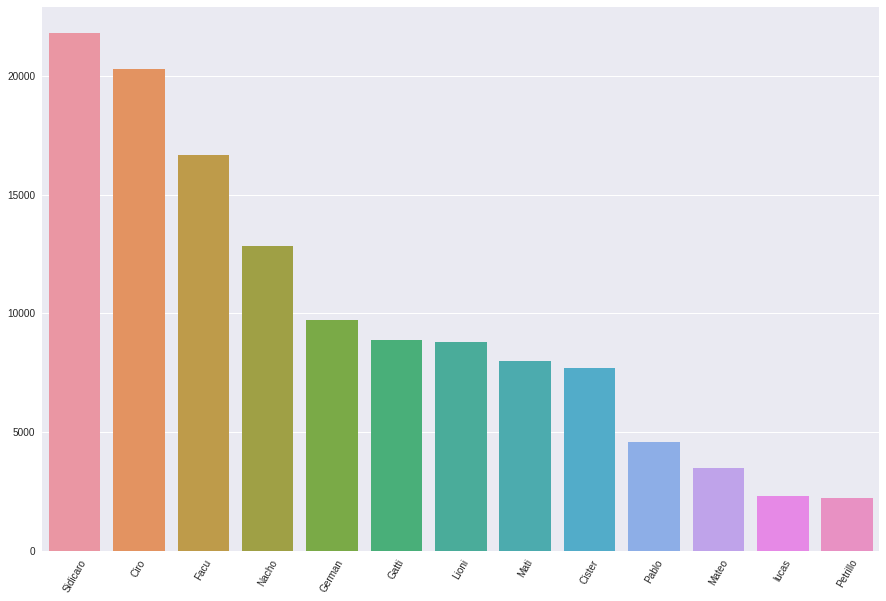

In [10]:
names =  df.name.value_counts().index
values = df.name.value_counts().values

plt.figure(figsize=(15, 10))
bar = sns.barplot(names, values)
bar.set_xticklabels(names, rotation=60);
values

## Actividad

In [11]:
gente = list(set(df.name.unique()) - set(['PollBot', 'Meeting Coordinator']))
len(gente)

13

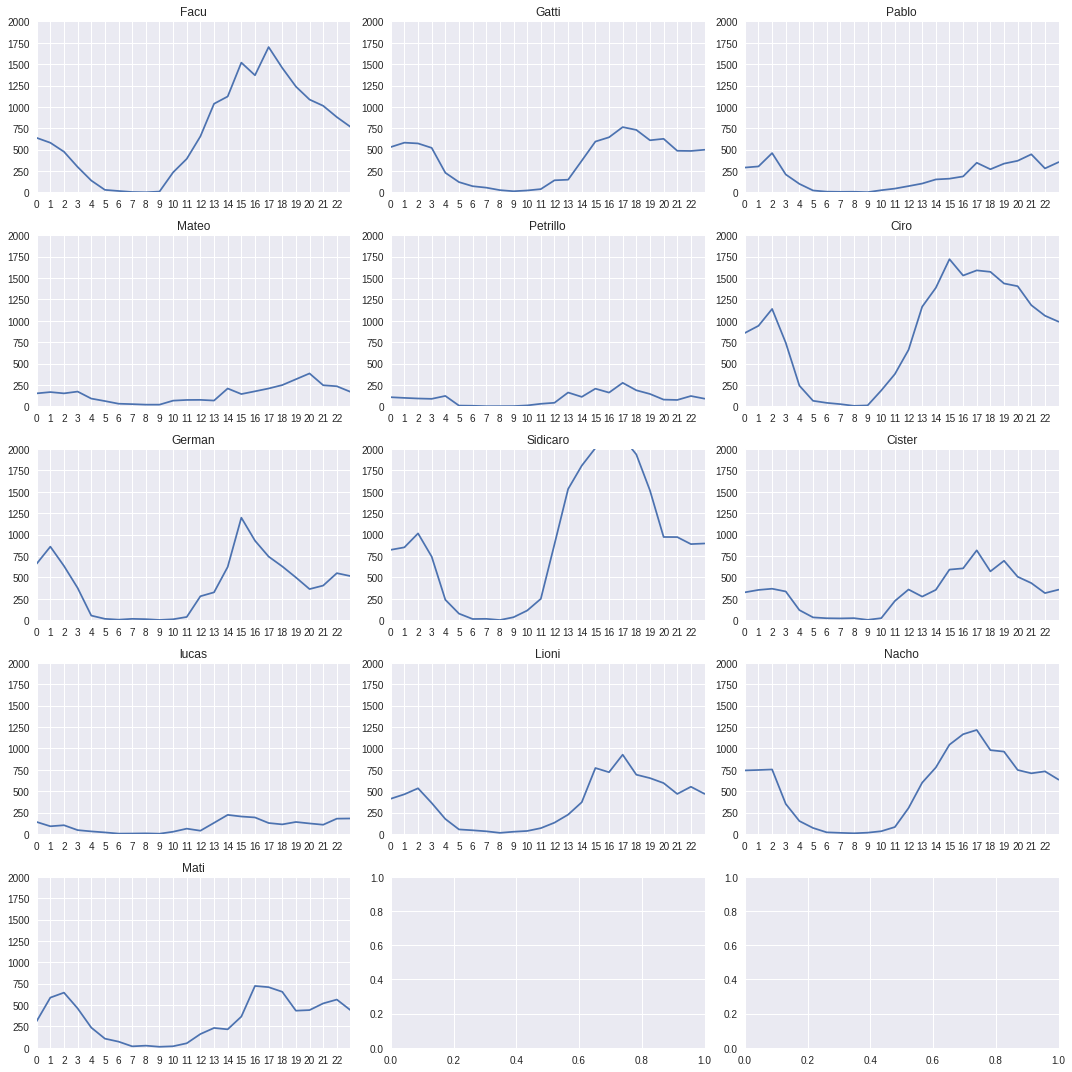

In [12]:
fig, axes = plt.subplots(5, 3, figsize = (15, 15))

i,j = 0,0
lista = []
for persona in gente:
    ax = axes[j][i]
    lista.append(df[df['name'] == persona].date.apply(lambda x: x.hour)\
        .value_counts().sort_index())
    df[df['name'] == persona].date.apply(lambda x: x.hour)\
        .value_counts().sort_index().plot(title = persona, ax = ax)
    ax.set_xticks(range(0, 23))
    ax.set_ylim(0, 2000)

    i += 1
    if i == 3:
        i = 0
        j += 1
        
plt.tight_layout()

In [13]:
por_hora = pd.DataFrame({p:l for p,l in zip(gente, lista)}).fillna(method = 'bfill').T

In [14]:
por_hora

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Ciro,857.0,941.0,1138.0,742.0,241.0,64.0,40.0,25.0,5.0,10.0,...,1385.0,1720.0,1529.0,1589.0,1572.0,1436.0,1404.0,1182.0,1059.0,989.0
Cister,325.0,353.0,367.0,335.0,117.0,32.0,22.0,20.0,23.0,3.0,...,354.0,591.0,605.0,816.0,570.0,694.0,507.0,433.0,316.0,356.0
Facu,638.0,581.0,476.0,298.0,139.0,30.0,17.0,5.0,2.0,10.0,...,1122.0,1518.0,1370.0,1700.0,1456.0,1238.0,1086.0,1013.0,881.0,767.0
Gatti,531.0,582.0,573.0,521.0,230.0,121.0,73.0,56.0,27.0,14.0,...,371.0,595.0,645.0,764.0,731.0,610.0,627.0,487.0,485.0,499.0
German,660.0,859.0,633.0,376.0,53.0,15.0,5.0,15.0,11.0,2.0,...,622.0,1198.0,929.0,743.0,628.0,499.0,363.0,404.0,549.0,515.0
Lioni,412.0,464.0,534.0,362.0,175.0,53.0,43.0,31.0,13.0,26.0,...,371.0,771.0,722.0,927.0,693.0,653.0,595.0,468.0,552.0,469.0
Mateo,151.0,166.0,151.0,172.0,90.0,61.0,30.0,25.0,19.0,19.0,...,208.0,143.0,175.0,208.0,248.0,316.0,384.0,246.0,234.0,169.0
Mati,312.0,587.0,645.0,461.0,236.0,107.0,72.0,17.0,25.0,12.0,...,216.0,365.0,723.0,709.0,655.0,434.0,441.0,519.0,564.0,440.0
Nacho,743.0,748.0,754.0,351.0,151.0,70.0,19.0,13.0,8.0,15.0,...,777.0,1044.0,1166.0,1216.0,980.0,963.0,748.0,709.0,732.0,635.0
Pablo,291.0,304.0,460.0,210.0,100.0,23.0,9.0,7.0,8.0,3.0,...,152.0,161.0,187.0,347.0,271.0,337.0,370.0,446.0,281.0,354.0


In [15]:
por_hora.T.corr().apply(lambda x: (np.sum(x)-1) / (len(x) - 1)).round(3)

Ciro        0.876
Cister      0.849
Facu        0.828
Gatti       0.845
German      0.790
Lioni       0.877
Mateo       0.710
Mati        0.790
Nacho       0.887
Pablo       0.696
Petrillo    0.775
Sidicaro    0.818
lucas       0.747
dtype: float64

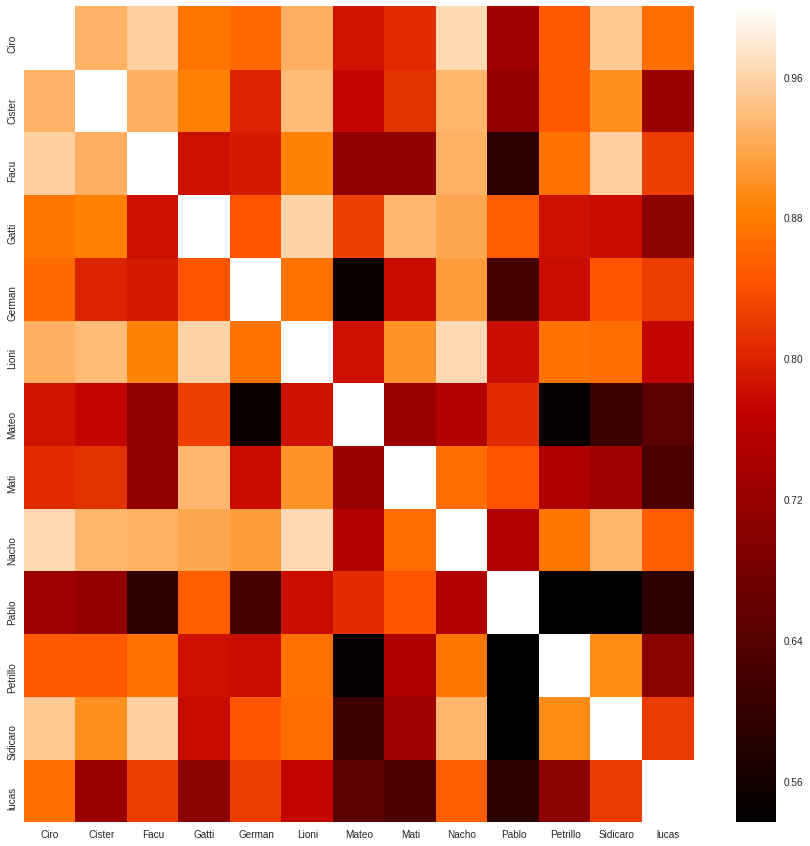

In [16]:
plt.figure(figsize=(15, 15))
sns.heatmap(por_hora.T.corr(), cmap='gist_heat')

## NLP

# Vocabulary

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
#def count_vocab(M):
#    global vocab...
#X.groupby(y).apply(count_vocab)

In [23]:
total_persona = df[~df.message.str.contains('<')].groupby('name').message.agg('sum')

In [27]:
countv = CountVectorizer().fit_transform(total_persona)

In [29]:
sum_total = np.array(countv.sum(axis = 1)).flatten() / df[~df.message.str.contains('<')].groupby('name').message.count().values

In [31]:
print(*sorted(zip(df[~df.message.str.contains('<')].groupby('name').count().index, sum_total), key = lambda x: x[1]), sep = '\n')

('lucas', 3.0257529463116541)
('Cister', 3.1828193832599121)
('Petrillo', 3.3604176123467999)
('Facu', 3.7141485659426379)
('Mateo', 3.7635115813554476)
('German', 4.1344295991778006)
('Ciro', 4.3280988480850642)
('Gatti', 4.4568858909499722)
('Mati', 4.8503248375812094)
('Sidicaro', 4.8576536927520282)
('Lioni', 4.9415577032404778)
('Pablo', 5.9700218818380746)
('Nacho', 6.1763516141579151)


In [32]:
df.message.apply(lambda x: ' '.join(re.findall('n+e+f+a+s+t+o', x, flags= re.IGNORECASE))).value_counts()

                   127247
nefasto               100
Nefasto                 7
NEFASTO                 3
nefasto nefasto         2
Nefasto nefasto         1
Name: message, dtype: int64

In [33]:
df.message.apply(lambda x: ' '.join(re.findall('c+r+i+s', x, flags= re.IGNORECASE))).value_counts()

             127058
cris            145
Cris            144
CRIS              6
cris cris         4
Cris Cris         2
Cris cris         1
Name: message, dtype: int64

In [34]:
df.message.apply(lambda x: len(re.findall('m+a+c+r+i+', x, flags= re.IGNORECASE))).value_counts()

0    127107
1       247
2         5
3         1
Name: message, dtype: int64

In [35]:
df.message.apply(lambda x: len(re.findall('m+a+c+r+i+', x, flags= re.IGNORECASE))).value_counts()

0    127107
1       247
2         5
3         1
Name: message, dtype: int64

In [36]:
df['bol'] = df.message.apply(lambda x: len(re.findall('b+o+l+u+d+', x)))

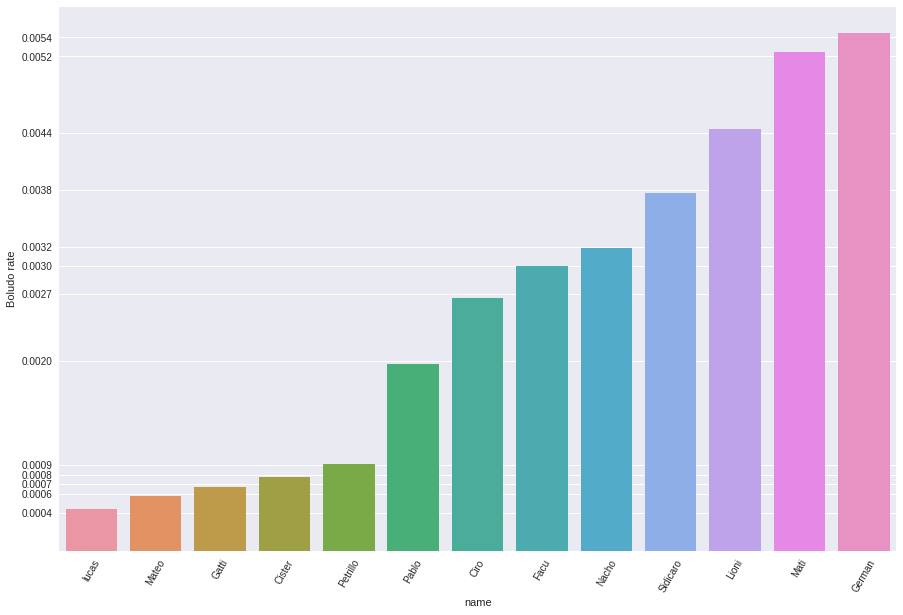

In [45]:
bol = (df.groupby('name').bol.sum() / (df[~df.message.str.contains('<')].groupby('name').bol.count())).fillna(0).sort_values()
plt.figure(figsize=(15, 10))
bar = sns.barplot(bol.index, bol.values)
bar.set_xticklabels(bol.index, rotation=60);
bar.set_yticks(np.around(bol.values, 4))
bar.set_ylabel('Boludo rate');

In [49]:
df[df['name'] == 'German'].message.str.contains('b+o+l+u+d+').sum()

53

# nltk?

In [51]:
import nltk
from nltk.tokenize import MWETokenizer, word_tokenize

In [27]:
total_persona = df.groupby('name').message.agg('sum')

In [28]:
total_total = ' '.join(total_persona.values)

In [29]:
total_total = re.sub('<.+?>', '', total_total)
#total_total = re.sub('<.+?>', '')

In [30]:
tokens = word_tokenize(total_total, language='spanish')

In [31]:
links = re.findall('(?:(?:http)|(?:www))[\s\S]+? ',total_total)

In [32]:
def stem(word):
    pattern = '.{,50}' + '+'.join([l for l in word]) + '.{,50}'
    return pattern

In [33]:
len(re.findall('\|\|', total_total))

0

In [34]:
sidi = (lambda x: re.findall(stem('sidi'), x, flags= re.IGNORECASE))(total_total)

In [35]:
sidi[:10]

['onfirmoO sea, yo voyFlashée que el de la foto era SidicaroCuál es la dirección de lioni?GraciasYo me pre',
 ' el barrio del colegioQué me recomiendan almorzar?SidicaroPreferentemente que no sean sanguches porque n',
 'aja anda a falsificar tu libreta SaadeQué onda la sidifiesta hoy? Es muy tarde si caigo a las 2?Qué orie',
 'alEs SaadeNo le sube el agua al tanqueHabrá otras SidicaroUn par de días de amargura y a otra cosaMe saq',
 'teY Quiroga no era liberalVenite a casa a ver Got Sidicaro#NoAflojamos#SiSePuedeMuy tarde para mí Mati, ',
 'foto de perfil es casi tan buena como los #stickerssidicaroLo más grasaCómo extraño la siesta en días de ',
 'semanaSo voEs el Sidicaro de la playlistJajajajY gana las eleccionesGor',
 'boboMira qué lindo está el díaAhí le peguéGracias sidi😍Ganó casaLo de la rola hacía referencia  a nadaPo',
 'bras enteroSi laburaste tres, la mitadSe entiende sidiLa hicieron los radicales no?JajajajaHoy me tiraro',
 'én Rivero le gusta estoUna seguidora de greenpeac

In [53]:
def quitar_tildes(words):
    if isinstance(words, list):
        return [''.join([l if l not in 'áéíúó' else 'aeiou'['áéíóú'.index(l)] for l in w]) for w in words]
    else:
        return ''.join([l if l not in 'áéíúó' else 'aeiou'['áéíóú'.index(l)] for l in words])

In [54]:
stop_words = nltk.corpus.stopwords.words('spanish')
stop_words_sintilde = quitar_tildes(stop_words)

# Modelado

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [62]:
X = df[~df.message.str.contains('<')].message.str.lower().apply(quitar_tildes)
y = df[~df.message.str.contains('<')].name

In [63]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [64]:
df.name.value_counts()

Sidicaro    21816
Ciro        20314
Facu        16668
Nacho       12858
German       9730
Gatti        8895
Lioni        8795
Mati         8004
Cister       7719
Pablo        4570
Mateo        3497
lucas        2291
Petrillo     2203
Name: name, dtype: int64

In [65]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words_sintilde)),
    #('rd', RandomForestClassifier()),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None)))])

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)}
'''"rd__max_depth": [3, None],
    "rd__max_features": range(1, 11),
    "rd__min_samples_split": range(2, 11),
    "rd__min_samples_leaf": range(1, 11),
    "rd__bootstrap": [True, False],
    "rd__criterion": ["gini", "entropy"]}'''
    
grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=5, n_jobs=4, verbose=1)
grid_search_tune.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...assifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'tfidf__max_df': (0.25, 0.5, 0.75), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'clf__estimator__alpha': (0.01, 0.001)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [66]:
print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)
grid_search_tune.best_score_

Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'mas', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'si', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'tambien', 'me', 'hasta', 'hay', 'donde'...tuviesemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
          n_jobs=1))]


0.2523321432684556

In [67]:
model = grid_search_tune.best_estimator_

             precision    recall  f1-score   support

       Ciro       0.31      0.33      0.32      5194
     Cister       0.22      0.14      0.17      1883
       Facu       0.26      0.27      0.26      4183
      Gatti       0.27      0.13      0.18      2259
     German       0.26      0.16      0.20      2362
      Lioni       0.20      0.11      0.14      2228
      Mateo       0.15      0.05      0.08       879
       Mati       0.35      0.25      0.30      1964
      Nacho       0.30      0.23      0.26      3244
      Pablo       0.21      0.08      0.12      1131
   Petrillo       0.20      0.04      0.07       541
   Sidicaro       0.23      0.52      0.32      5396
      lucas       0.18      0.04      0.07       574

avg / total       0.26      0.26      0.24     31838



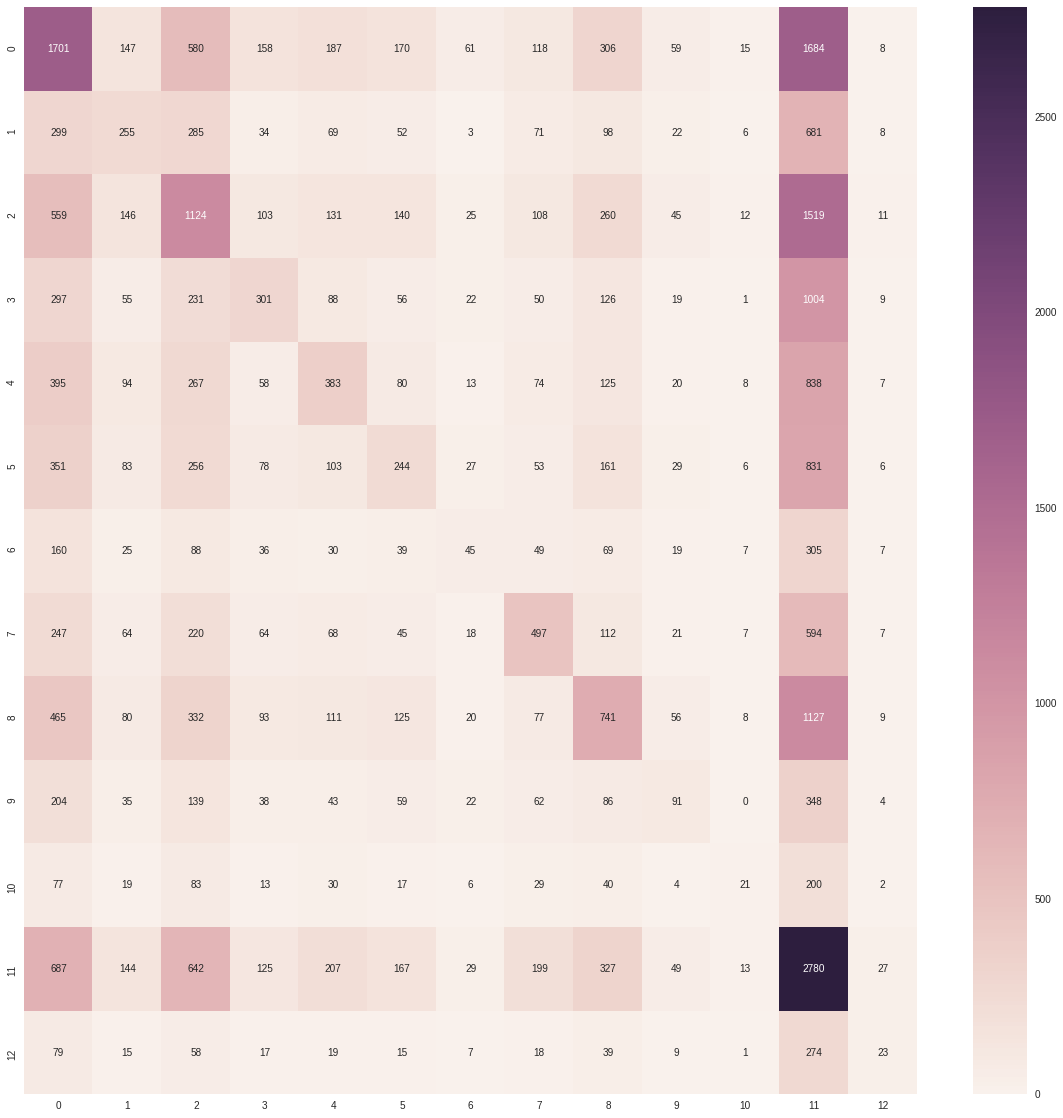

In [68]:
ypred = grid_search_tune.predict(Xtest)
print(classification_report(ytest, ypred))
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(ytest, ypred), annot= True,  fmt='g')

In [70]:
libros = 'ross 841, rice 685, isrl 440, apostol 837, strang 587, elements of stats 764, neural ts 615, theor neuro 447, kandel 1230'.split(',')

In [77]:
sum([int(''.join(re.findall('\d+', b))) for b in libros])

6446